In [16]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain = '../Data/train/train'
dirDev   = '../Data/dev/dev'

In [15]:
listTrain= os.listdir(os.path.join(dirTrain,'level-1')); len(listTrain); listTrain[:12]
listTrainNN = []
for ff in listTrain :
    if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
len(listTrainNN), listTrainNN[:15]

(751,
 ['1014',
  '1016',
  '1040',
  '962',
  '971',
  '97',
  '980',
  '992',
  '919',
  '93',
  '942',
  '953',
  '961',
  '4292',
  '42'])

In [128]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        for i in range(3):
            kn = kp[i]
            print ("(x,y)=",kn.pt,"size=",kn.size,"angle=",kn.angle,"response=",kn.response,"octave=",kn.octave,"class_id=",kn.class_id)
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        if False :
            matchesX = []
            for m in matches :
                if  kp1[m.queryIdx].pt[1] >= 500 and kp1[m.queryIdx].pt[1] <=1000 and kp2[m.trainIdx].pt[1] >= 500 and kp2[m.trainIdx].pt[1] <=1000 :
                    matchesX.append(m);
            matches = matchesX;
        #print ("KP(1,2):",len(kp1),len(kp2)," Matches:",len(matches),matches[0].distance)
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [135]:

NN=19
print(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'.tif'))
img1 = cv.imread(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'.tif'),-1)
img2 = cv.imread(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'_ref.tif'),-1)


../Data/train/train/level-1/246.tif


4 0


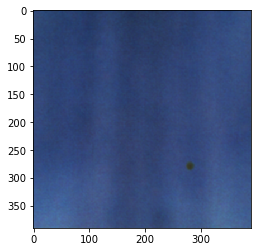

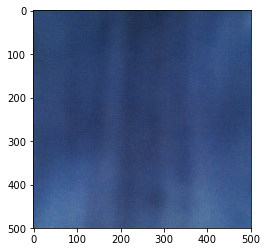

error: /io/opencv/modules/core/src/stat.cpp:3934: error: (-215) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function batchDistance


In [163]:
img1      = cv.GaussianBlur(img1,(3,3),0)
img2      = cv.GaussianBlur(img2,(3,3),0)
kp1, des1 = computeORB(img1)
kp2, des2 = computeORB(img2)

print(len(kp1), len(kp2))
plt.imshow(img1); plt.show()
plt.imshow(img2); plt.show()

matches = drawMatches(img1,kp1,des1, img2,kp2,des2, show=True)
#drawMatches(img2,kp2,des2, img1,kp1,des1, show=True)

print(len(kp1), len(kp2), len(matches))
for mm in matches[:20] : print(mm.distance)


In [179]:

NN=12
res = []
#print(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'.tif'))
for NN in range(len(listTrainNN)) :
    #print(NN)
    img1 = cv.imread(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'.tif'),-1)
    img2 = cv.imread(os.path.join(dirTrain,'level-1',listTrainNN[NN]+'_ref.tif'),-1)
    #img1      = cv.GaussianBlur(img1,(3,3),0)
    #img2      = cv.GaussianBlur(img2,(3,3),0)
    kp1, des1 = computeORB(img1)
    kp2, des2 = computeORB(img2)
    matches = []
    if len(kp1)>0 and len(kp2)>0 :
        matches = drawMatches(img1,kp1,des1, img2,kp2,des2, show=False)
    res.append([len(kp1),len(kp2),len(matches),
                (matches[0].distance if len(matches)>0 else -1),
                (matches[-1].distance if len(matches)>0 else -1)])


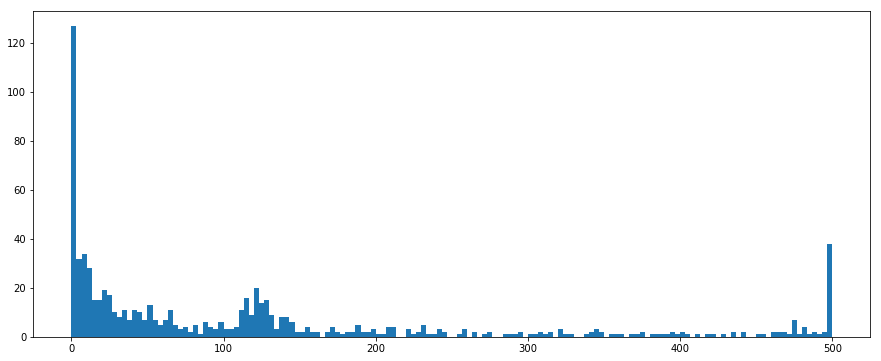

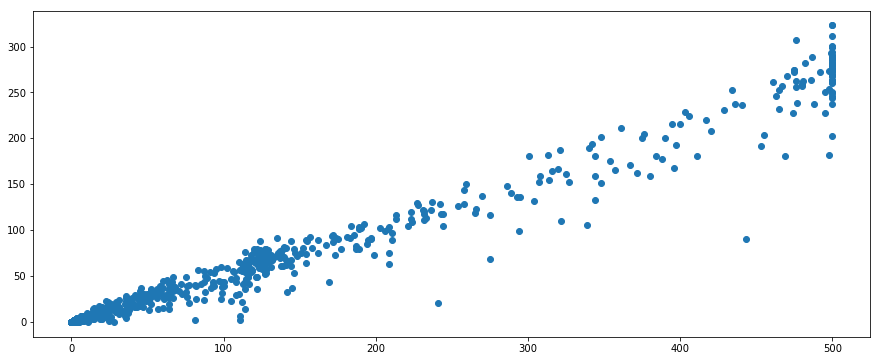

In [180]:
plt.figure(figsize=(15,6));
plt.hist([k2 for k1,k2,mm,mm0,mmM in res],bins=150); plt.show()
plt.figure(figsize=(15,6));
plt.scatter([k2 for k1,k2,mm,mm0,mmM in res],[mm for k1,k2,mm,mm0,mmM in res]); plt.show()

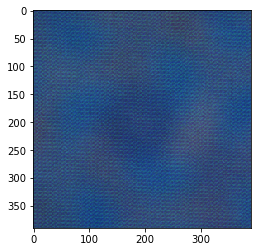

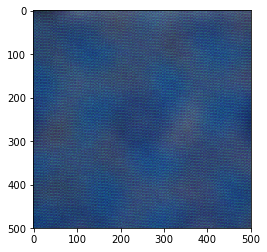

In [31]:
plt.imshow(img1); plt.show()
plt.imshow(img2); plt.show()